In [ ]:
import cv2
import os
from mtcnn import MTCNN
import math

fake_faces_count = 0
max_count = 2875

def extract_and_crop_faces(video_path, output_folder, skip_frames):
    global fake_faces_count  
    if not os.path.exists(output_folder):
        os.makedirs(output_folder, exist_ok=True)

    video_name = os.path.splitext(os.path.basename(video_path))[0]
    faces_dir = os.path.join(output_folder, video_name)
    os.makedirs(faces_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  
    detector = MTCNN()
    count = 0

    while cap.isOpened():
        frame_id = cap.get(cv2.CAP_PROP_POS_FRAMES)
        success, frame = cap.read()
        if not success:
            break

        if frame_id % skip_frames == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = detector.detect_faces(frame)

            for i, result in enumerate(faces):
                if fake_faces_count >= max_count:
                    continue  
                bounding_box = result['box']
                confidence = result['confidence']

                if confidence > 0.95:
                    x1, y1, width, height = bounding_box
                    cropped_image = frame[y1:y1+height, x1:x1+width]
                    face_filename = f'{video_name}-{count:04d}-{i:02d}.png'
                    cv2.imwrite(os.path.join(faces_dir, face_filename), cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))
                    fake_faces_count += 1  

            count += 1

    cap.release()
    print(f"Processed video and extracted faces: {video_path}")

def process_multiple_videos(video_folder, output_folder, interval_seconds=3):
    global fake_faces_count  
    for video_file in os.listdir(video_folder):
        if video_file.lower().endswith('.mp4'):
            video_path = os.path.join(video_folder, video_file)
            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            skip_frames = int(fps * interval_seconds)  
            cap.release()
            extract_and_crop_faces(video_path, output_folder, skip_frames)

video_folder = 'D:/DeepFakeImageDetection/Celeb-DF-v2/Celeb-synthesis' 
output_folder = 'D:/DeepFakeImageDetection/Celeb-DF-v2/images/1_fake_images_from_videos' 

process_multiple_videos(video_folder, output_folder)

In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input

IMAGE_SIZE = 128

def load_images_and_labels_from_subfolders(folder, label):
    images = []
    labels = []
    # Walk through all files in the folder
    for root, dirs, files in os.walk(folder):
        for file_name in files:
            if file_name.lower().endswith('.png'):
                img_path = os.path.join(root, file_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
                img = preprocess_input(img)
                images.append(img)
                labels.append(label)  
    return images, labels

def load_and_combine_data(real_image_folder, fake_image_folder):
    real_images, real_labels = load_images_and_labels_from_subfolders(real_image_folder, 0)  
    fake_images, fake_labels = load_images_and_labels_from_subfolders(fake_image_folder, 1)  
    images = np.array(real_images + fake_images)
    labels = np.array(real_labels + fake_labels)
    return images, labels

def split_data(X, y, train_size=0.8, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, stratify=y)
    return X_train, y_train, X_test, y_test

real_image_folder = 'D:/DeepFakeImageDetection/Celeb-DF-v2/images/0_real_images_from_videos/'
fake_image_folder = 'D:/DeepFakeImageDetection/Celeb-DF-v2/images/1_fake_images_from_videos/'

X, y = load_and_combine_data(real_image_folder, fake_image_folder)
X_train, y_train, X_test, y_test = split_data(X, y)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')

Training data shape: (4544, 128, 128, 3), Training labels shape: (4544, 2)
Testing data shape: (1137, 128, 128, 3), Testing labels shape: (1137, 2)


In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import os

# Constants
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20

def create_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True
    fine_tune_at = 100  
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)  # Adjust dropout rate here
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
def create_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('D:/DeepFakeImageDetection/models/best_model.keras', save_best_only=True, verbose=1)
    return [early_stopping, model_checkpoint]
model = create_model((IMAGE_SIZE, IMAGE_SIZE, 3), 2)
model.summary()
callbacks = create_callbacks()
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 21,553,154 (82.22 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7757 - loss: 0.4605
Epoch 1: val_loss improved from inf to 0.18831, saving model to D:/DeepFakeImageDetection/models/best_model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 466s 2s/step - accuracy: 0.7764 - loss: 0.4595 - val_accuracy: 0.9481 - val_loss: 0.1883
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9756 - loss: 0.0713
Epoch 2: val_loss improved from 0.18831 to 0.12246, saving model to D:/DeepFakeImageDetection/models/best_model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.9756 - loss: 0.0713 - val_accuracy: 0.9604 - val_loss: 0.1225
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9913 - loss: 0.0328
Epoch 3: val_loss did not improve from 0.12246
142/142 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.9913 - loss: 0.0328 - val_accuracy: 0.9569 - val_loss: 0.1559
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9902 - loss: 0.0242
Epoch 4: val_loss did not i

In [83]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCHS = 20
BATCH_SIZE = 32

def create_callbacks(index):
    # EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        f'D:/DeepFakeImageDetection/models/bet_model_{index}.keras',   # Dynamic filename based on the index
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    return [early_stopping, model_checkpoint]
i = 1  

callbacks = create_callbacks(i) 
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=callbacks  # Use the callbacks created for this session
)
i += 1

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.6350 - loss: 0.7380
Epoch 1: val_loss improved from inf to 0.47537, saving model to D:/DeepFakeImageDetection/models/bet_model_1.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 832s 3s/step - accuracy: 0.6354 - loss: 0.7374 - val_accuracy: 0.7854 - val_loss: 0.4754
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7736 - loss: 0.5005
Epoch 2: val_loss improved from 0.47537 to 0.42798, saving model to D:/DeepFakeImageDetection/models/bet_model_1.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 107s 714ms/step - accuracy: 0.7736 - loss: 0.5004 - val_accuracy: 0.8179 - val_loss: 0.4280
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.8254 - loss: 0.4194
Epoch 3: val_loss improved from 0.42798 to 0.39637, saving model to D:/DeepFakeImageDetection/models/bet_model_1.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 99s 699ms/step - accuracy: 0.8254 - loss: 0.4193 - val_accuracy: 0.8311 - val_loss: 0.3964
Epoch 4/20
142/142 ━━━━━

In [14]:
model.save('D:/DeepFakeImageDetection/models/model4.keras')

In [22]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical

IMAGE_SIZE = 128

def load_images_and_labels_from_subfolders(folder, label):
    images = []
    labels = []
    image_paths = []  # List to store the paths of the images
    for subdir, dirs, files in os.walk(folder):
        for file_name in files:
            if file_name.lower().endswith('.png'):
                img_path = os.path.join(subdir, file_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue  # Skip files that can't be opened
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
                img = preprocess_input(img)
                images.append(img)
                labels.append(label)
                image_paths.append(img_path)
    return images, labels, image_paths

def load_validation_data(real_folder, fake_folder):
    X_real, y_real, paths_real = load_images_and_labels_from_subfolders(real_folder, 0)
    X_fake, y_fake, paths_fake = load_images_and_labels_from_subfolders(fake_folder, 1)

    X_val = np.array(X_real + X_fake)
    y_val = np.array(y_real + y_fake)
    paths_val = paths_real + paths_fake
    return X_val, y_val, paths_val

real_folder = 'D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/'
fake_folder = 'D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/fake/'
X_val, y_val, image_paths = load_validation_data(real_folder, fake_folder)
y_val = to_categorical(y_val, num_classes=2)
print(f'Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}')
print(f'Number of image paths: {len(image_paths)}')

Validation data shape: (50, 128, 128, 3), Validation labels shape: (50, 2)
Number of image paths: 50


In [16]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5979 - loss: 0.6221
Validation Loss: 0.5967452526092529
Validation Accuracy: 0.6000000238418579


In [26]:
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model('D:/DeepFakeImageDetection/models/model4.keras')
y_pred = model.predict(X_val)

for prediction, path in zip(y_pred, image_paths):
    label = 'Real' if np.argmax(prediction) == 0 else 'Fake'
    print(f'{label}: {path}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 8s/step
Real: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_1112.png
Real: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_145.png
Fake: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_147.png
Real: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_176.png
Real: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_183.png
Real: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_185.png
Real: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_201.png
Real: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_218.png
Fake: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_260.png
Real: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_275.png
Fake: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_322.png
Real: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_390.png
Fake: D:/DeepFakeImageDetection/Celeb-DF-v2/images/val/real/real_426.png
Fake: D:/Deep

36/36 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step


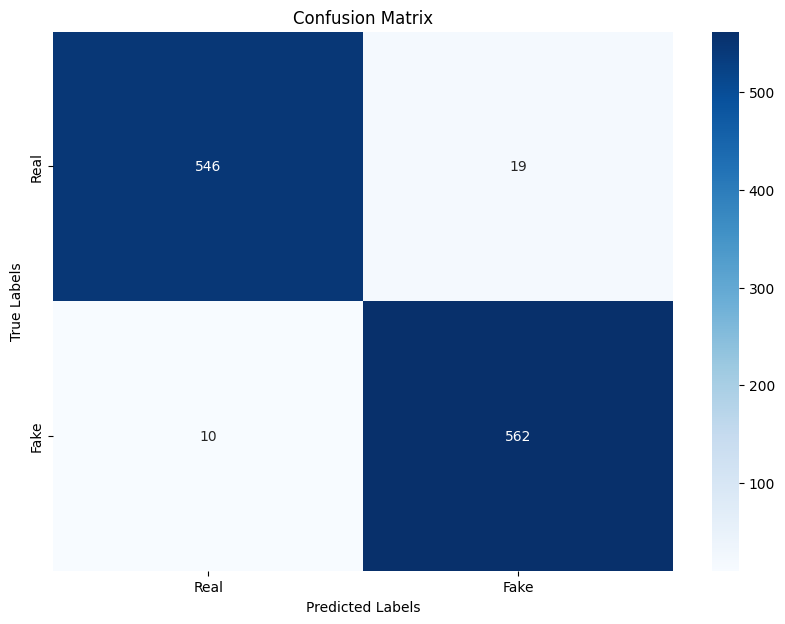

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np
predictions = model.predict(X_test)
predictions_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  # Only do this if y_test is one-hot encoded
conf_matrix = confusion_matrix(true_labels, predictions_labels)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5979 - loss: 0.6221


[0.5967452526092529, 0.6000000238418579]

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()